In [3]:
# Example scipt using MesoPy to Download multiple station/variable and save to a netcdf format using xary
# Created by Nic Wayand (https://github.com/NicWayand/MesoWestDownload)
from MesoPy import Meso
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import xray
import pandas as pd
from netCDF4 import Dataset
from datetime import datetime, timedelta
# OS interaction
import sys
import os

####### USER INPUT ##################

## Your Meswest token
# Email MesoWest API <mesowestapi@gmail.com> to request a API token
m = Meso(token=your token goes here)

## Local Path and file name of output netcdf file
ncfilename = os.path.normpath('YOUR PATH HERE TEST.nc')

## Select Stations

#1) Manually
#sta_id = ['ksea','sno38','alp44','ksmp','keln']

#2) Select stations from lat lon box
stations = m.metadata(bbox=[-121.837006,47.214409,-121.015778,47.547306])
# Get Station sta_id
# Convert List to nuppy array
N_sta_in = stations['SUMMARY']['NUMBER_OF_OBJECTS']
sta_id = np.empty(N_sta_in,dtype='|S10')
for n,x in enumerate(stations['STATION']):
    sta_id[n] = x['STID']

## Define variable names to extract
# uncomment below to see available variables
#print m.variables()
#  Examples
Vars_ext = ['air_temp_set_1','wind_speed_set_1','wind_direction_set_1','weather_cond_code_set_1'] 


## Define Time period

#1) Short time period
StartDate = datetime(2015,1,1,0,0) 
EndDate   = datetime(2015,1,30,23,0)

#####################################

In [4]:
# Uncomment below to see what informaiton stations contains
#stations

In [5]:
# Function Get_data returns a xray.DataSet of reqested station data/metadata
def Get_data(m,sta_id,Vars_ext,StartDate,EndDate):
    # INPUT
    # m MESOWEST token variable
    # sta_id list of station ids requested
    # Vars_ext list of variables requested
    # StateDate start of data
    # EndDate end of data
    
    #### Function for combining xray data variables into a single array with new labeled dimension
    # Creator Karl Lapo
    def combinevars(ds_in,dat_vars,new_dim_name='new_dim',combinevarname='new_var'):
        ds_out = xray.Dataset()
        ds_out = xray.concat([ds_in[dv] for dv in dat_vars],dim='new_dim')
        ds_out = ds_out.rename({'new_dim': new_dim_name})
        ds_out.coords[new_dim_name] = dat_vars
        ds_out.name = combinevarname

        return ds_out

    # Grab all time series data from all stations for a given date range
    print 'Grabbed all station data'
    allstationdata = m.timeseries(stid=sta_id, start=StartDate, end=EndDate)

    # Get Station Info
    N_sta = allstationdata['SUMMARY']['NUMBER_OF_OBJECTS']
    print 'Found ',N_sta,' Stations'
    Elev  = [ast.literal_eval(json.dumps(allstationdata['STATION'][cs]['ELEVATION'])) for cs in range(0,N_sta)]
    Lat   = [ast.literal_eval(json.dumps(allstationdata['STATION'][cs]['LATITUDE'])) for cs in range(0,N_sta)]
    Lon   = [ast.literal_eval(json.dumps(allstationdata['STATION'][cs]['LONGITUDE'])) for cs in range(0,N_sta)]
    NAME  = [ast.literal_eval(json.dumps(allstationdata['STATION'][cs]['NAME'])) for cs in range(0,N_sta)]
    ID    = [ast.literal_eval(json.dumps(allstationdata['STATION'][cs]['STID'])) for cs in range(0,N_sta)]
    print 'Got all station info'
    
    if N_sta == 0: # No stations were found for this period
        return None
    
    # Get timestamp timeseries for all stations (may be different lengths and different time steps)
    timestamp = []
    [timestamp.append(ob['OBSERVATIONS']['date_time']) for ob in allstationdata['STATION']]
    print 'Got timestamps for each station'
    
    # Loop through each variable to extract
    print 'Looping through each station to extract data'
    DS_list = [] # Empty list of each dataset containing one variable
    for Vn,cVar in enumerate(Vars_ext):
        print 'Current variable is ',cVar
        # Get timeseries of data for all stations
        temp_list = []
        for Sn,ob in enumerate(allstationdata['STATION']):
            #print ob['NAME']
            # Not all stations have all variables, which will throw an error
            # If station has this Variable
            try:
                temp_list.append(ob['OBSERVATIONS'][cVar])
            # Else add missing values as padding (so xray can handel it)
            except: 
                # Create empty array of -9999
                temp_vals = np.empty(np.size(timestamp[Sn]))
                temp_vals[:] = np.NAN
                temp_list.append(temp_vals)
                print 'Station ',ob['NAME'],' is missing ',[cVar],'Padding with -9999s'
                
        print 'Got ',cVar,'data from',len(temp_list),'stations'   
        
        # Make dictionary of site and xray data array
        # Warning, must cast returned types to float64
        print '.....Converting to a dictionary list of xray.DataArrays'
        dict1 = {}
        for csta in range(0,len(temp_list)):
            c_t = [datetime.strptime(ast.literal_eval(json.dumps(timestamp[csta][cd])), '%Y-%m-%dT%H:%M:%SZ') for cd in range(len(timestamp[csta]))]
            dict1[ID[csta]] = xray.DataArray(np.array(temp_list[csta],dtype='float64'), coords=[c_t], dims=['time'], name=ID[csta])
        #print dict1
        
        # Make it a dataset
        print '.....Converting to a xray.Dataset'
        ds_temp_Var = xray.Dataset(dict1)
        #print ds_temp_Var
            
        # Resample to common time step as Data contains mix of 15, 10, and 5 min data
        # For some variables we want to sample
        if cVar=='wind_direction_set_1':  
            print '.....Resampling to 1 hour time step. Using Median!!!! Timestamp out is END of period!!!!'
            ds_temp_Var_1hr = ds_temp_Var.resample(freq='H',dim='time',how='median',label='right')
            #print ds_temp_Var_1hr
        else:
            print '.....Resampling to 1 hour time step. Using mean!!!! Timestamp out is END of period!!!!'
            ds_temp_Var_1hr = ds_temp_Var.resample(freq='H',dim='time',how='mean',label='right')
            #print ds_temp_Var_1hr

        # Combine stations
        print '.....Combining stations'
        DS_list.append(combinevars(ds_temp_Var_1hr,ds_temp_Var_1hr.data_vars,new_dim_name='site',combinevarname=cVar))
        
    # Make dictionary list
    DIC1 = dict(zip([cv.name for cv in DS_list],DS_list))
    
    # Combine all Datasets
    print 'Combine all datasets (if multple varibles requested)'
    ds_ALL = xray.Dataset(DIC1)
    #print ds_ALL
    
    print 'Update coords'
    # Fill in descriptive variables
    ds_ALL.coords['lat'] = ('site',[float(x) for x in Lat])
    ds_ALL.coords['lon'] = ('site',[float(x) for x in Lon])
    ds_ALL.coords['elev'] = ('site',[float(x) for x in Elev])
    ds_ALL.coords['sta_name'] = ('site',NAME)
    
    return ds_ALL

In [6]:
# MesoWest only allows ~2 years of data to be downloaded at a time
# Therefore, we split up our requests into year chunks
# if multple years were requested

# Number of years we requested
N_years = int((EndDate-StartDate).total_seconds()/(365*24*60*60))

# Initialize data
c_DS = []

# If requested less than 1 year
if N_years < 1:
    c_DS.append(Get_data(m,sta_id,Vars_ext,StartDate.strftime('%Y%m%d%H%M'),EndDate.strftime('%Y%m%d%H%M')))
# Need to cycle through each year at a time
else:
    Year_rng = pd.date_range(start=StartDate, periods=N_years, freq=pd.DateOffset(years=1))
    # For each calender year
    for cY in range(1,len(Year_rng)):
        c_date_S = Year_rng[cY-1].strftime('%Y%m%d%H%M') # format needed '201210010000'
        c_date_E = Year_rng[cY].strftime('%Y%m%d%H%M') # format needed '201210010000'
        print 'Downloading data ' + c_date_S + ' through ' + c_date_E

        # Attempt to download data
        temp_DS = Get_data(m,sta_id,Vars_ext,c_date_S,c_date_E)

        # Check if any data was found, if so add the DS to the list
        if temp_DS is not None:
            c_DS.append(temp_DS)

    # Get last period of data (fence post)
    print 'Downloading data ' + Year_rng[-1].strftime('%Y%m%d%H%M') + ' through ' + EndDate.strftime('%Y%m%d%H%M')
    c_DS.append(Get_data(m,sta_id,Vars_ext,Year_rng[-1].strftime('%Y%m%d%H%M'),EndDate.strftime('%Y%m%d%H%M')))
print 'Finished downloading data'

Grabbed all station data
Found  38  Stations
Got all station info
Got timestamps for each station
Looping through each station to extract data
Current variable is  air_temp_set_1
Station  RAIN GAGE CEDAR LAKE NEAR  NORTH BEND 7SSE  is missing  ['air_temp_set_1'] Padding with -9999s
Station  SOUTH FORK SNOQUALMIE RIVER ABOVE ALICE CREEK NEAR NORTH BEND 11SE  is missing  ['air_temp_set_1'] Padding with -9999s
Station  CHESTER MORSE LAKE AT CEDAR FALLS NEAR NORTH BEND 7SSE  is missing  ['air_temp_set_1'] Padding with -9999s
Station  Snoqualmie Pass  is missing  ['air_temp_set_1'] Padding with -9999s
Got  air_temp_set_1 data from 38 stations
.....Converting to a dictionary list of xray.DataArrays
.....Converting to a xray.Dataset
.....Resampling to 1 hour time step. Using mean!!!! Timestamp out is END of period!!!!
.....Combining stations
Current variable is  wind_speed_set_1
Station  Alpental Base  is missing  ['wind_speed_set_1'] Padding with -9999s
Station  Alpental Summit  is missing  

In [86]:
# check what we got!
print c_DS

[<xarray.Dataset>
 Dimensions:                  (site: 38, time: 720)
 Coordinates:
   * time                     (time) datetime64[ns] 2015-01-01T01:00:00 ...
   * site                     (site) |S5 'D1832' 'TFRAN' 'TEAST' 'THOME' ...
     lat                      (site) float64 47.44 47.44 47.47 47.44 47.41 ...
     lon                      (site) float64 -121.4 -121.4 -121.7 -121.8 ...
     elev                     (site) float64 3.1e+03 5.47e+03 604.0 1.01e+03 ...
     sta_name                 (site) |S66 'Alpental Base' 'Alpental Summit' ...
 Data variables:
     wind_speed_set_1         (site, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
     weather_cond_code_set_1  (site, time) float64 nan nan nan nan nan nan ...
     wind_direction_set_1     (site, time) float64 nan nan nan nan nan nan ...
     air_temp_set_1           (site, time) float64 -0.265 -1.007 -1.567 ...]

In [87]:
# In case any sites/variables were missing from a given year
# Align each Dataset (fill missing stations/variables with NaN)
#newDS = xray.align(*c_DS, join='outer', copy=True)
newDS = xray.auto_combine(c_DS)
#print newDS

<xarray.Dataset>
Dimensions:                  (site: 38, time: 720)
Coordinates:
  * time                     (time) datetime64[ns] 2015-01-01T01:00:00 ...
  * site                     (site) |S5 'D1832' 'TFRAN' 'TEAST' 'THOME' ...
    lat                      (site) float64 47.44 47.44 47.47 47.44 47.41 ...
    lon                      (site) float64 -121.4 -121.4 -121.7 -121.8 ...
    elev                     (site) float64 3.1e+03 5.47e+03 604.0 1.01e+03 ...
    sta_name                 (site) |S66 'Alpental Base' 'Alpental Summit' ...
Data variables:
    wind_speed_set_1         (site, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    weather_cond_code_set_1  (site, time) float64 nan nan nan nan nan nan ...
    wind_direction_set_1     (site, time) float64 nan nan nan nan nan nan ...
    air_temp_set_1           (site, time) float64 -0.265 -1.007 -1.567 ...


[[<matplotlib.lines.Line2D at 0xf271518>],

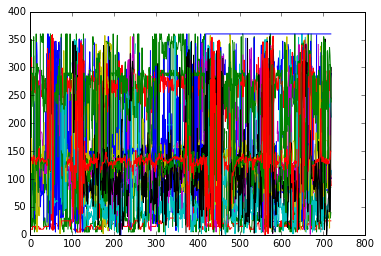

In [90]:
# Plot some data   (change wind_direction_set_1 to what ever variable you have downloaded)
vartoplot = newDS.wind_direction_set_1  
[plt.plot(vartoplot.isel(site=csta)) for csta in range(0,newDS.site.values.size)]

In [91]:
## Output to netcdf
newDS.to_netcdf(ncfilename)